In [1]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

2024-02-01 16:25:22.291578: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 16:25:22.318503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 16:25:22.318527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 16:25:22.319177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 16:25:22.323311: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 16:25:22.323630: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = 0.3 #Std for noisy networks (put None if you don't want a noisy network)
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'post'

In [4]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [5]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [6]:
agent.train(env,1000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition))

0 0.497
1 0.50275
2 0.5003333333333334
3 0.496375
4 0.4949
5 0.4943333333333333
6 0.4927857142857142
7 0.4933125
8 0.4958888888888889
9 0.49615
10 0.49735000000000007
11 0.49605
12 0.49784999999999996
13 0.49905
14 0.5002
15 0.5024
16 0.5035999999999998
17 0.5045999999999999
18 0.5059499999999999
19 0.5058
20 0.5051499999999999
21 0.5068499999999999
22 0.5065500000000001
23 0.5098999999999999
24 0.5113000000000001
25 0.51105
26 0.5127999999999999
27 0.5148499999999999
28 0.515
29 0.5190499999999999
30 0.5231999999999999
31 0.52455
32 0.5276000000000001
33 0.5284000000000001
34 0.5293500000000001
35 0.5333
36 0.5377500000000001
37 0.5406000000000001
38 0.5424
39 0.5435
40 0.5474500000000001
41 0.5532
42 0.5562500000000001
43 0.56045
44 0.56835
45 0.57265
46 0.5747
47 0.5798
48 0.5839000000000001
49 0.58975
50 0.59065
51 0.5917000000000001
52 0.5939500000000001
53 0.59435
54 0.5933999999999999
55 0.597
56 0.6010500000000001
57 0.60175
58 0.6033000000000001
59 0.6041000000000001
60 0.6082

In [ ]:
agent.save('UniversalRNN-'+str(condition))

SAVING ['nn', 'out_nn']


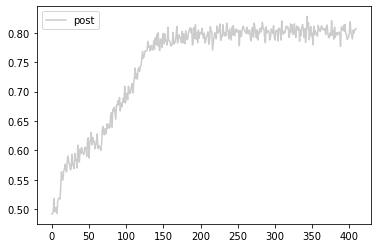

In [ ]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [ ]:
env = Env(deck_size,kappa=0.5,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [ ]:
agent.load('UniversalRNN-'+str(condition))

LOADING ['nn', 'out_nn']


In [ ]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [ ]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1,2] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [ ]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [ ]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [ ]:
out = agent.nn(batch_obs).numpy()[:,-1:,:]
choice = agent.predict(batch_obsf).numpy()

In [ ]:
#Residue ref
#ref = batch_obsf.get('obs')[:,:,2:].reshape((-1,2))
#out = residue(out,ref)

#Residue choice
choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
out = residue(out, choice_batch)

score 0.028810760099950795


In [ ]:
#fit pca
pca = fit_pca(out.reshape((-1,64)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,64))).reshape(out.shape[:-1]+(nb_variance,))

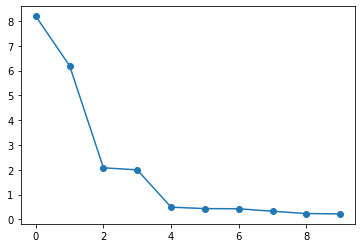

In [ ]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [ ]:
#Plot background function
def plot_bg(pca_batch,ax,zorder=0):
    
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    print(len(colors),pca_batch.shape)
    colors = [['blue' if choice[j] else 'darkorange' for j in range(pca_batch.shape[0])] for i in range(pca_batch.shape[1])]
    #cyclic colormap
    cm = plt.get_cmap('rainbow')
    colors = [[cm(ref/(2*np.pi)) for ref in batch_obsf.get('ref')[:]] for i in range(pca_batch.shape[1])]
    unique_refs = np.unique(batch_obsf.get('ref'))
    for i,r in enumerate(unique_refs):
        c = cm(r/(2*np.pi))
        label = str(r/np.pi)+'pi'
        ax.plot([0],[0],[0],color=c,label=label,zorder=zorder)
    for i in range(pca_batch.shape[1]):
        
        alpha = 0.1
        ax.scatter(pca_batch[:,i,1],pca_batch[:,i,2],pca_batch[:,i,3],color=colors[i],alpha=alpha,marker='.',zorder=zorder,s=100)

        # Get the trajectory of the first item
        #trajectory = pca_batch[0]

        # Plot the trajectory
        #ax.plot3D(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],marker='o')
    plt.legend()
#Returns a grid of the latent space (for categorisation field)
def get_batch_state(pca_batch,res=10,return_grid=False):
    axis_x = np.linspace(np.min(pca_batch[:,:,0]),np.max(pca_batch[:,:,0]),10)
    axis_y = np.linspace(np.min(pca_batch[:,:,1]),np.max(pca_batch[:,:,1]),10)
    axis_z =np.linspace(np.min(pca_batch[:,:,2]),np.max(pca_batch[:,:,2]),10)
    X,Y,Z = np.meshgrid(axis_x,axis_y,axis_z)
    M=np.concatenate([X[:,:,:,None],Y[:,:,:,None],Z[:,:,:,None]],axis=3)
    print(M.shape)
    Zr = np.reshape(M,(-1,3))

    proj_mat = pca.components_[pca_axes]

    Zrp = np.dot(Zr,proj_mat)

    batch_state = Zrp

    out = tf.convert_to_tensor(batch_state,dtype=tf.float64)
    if return_grid:
        return out,Zr
    return out
def plot_categorisation_field(pca_batch,ax,zorder=10):
    c = 0.1
    batch_state,grid = get_batch_state(pca_batch,return_grid=True)
    out_batch = agent.out_dense(batch_state)
    for k in range(out_batch.shape[0]):
        ax.plot([grid[k][0]],[grid[k][1]],[grid[k][2]],color='orange',marker='o',alpha=out_batch[k,0].numpy().item()*c,zorder=zorder)
        ax.plot([grid[k][0]],[grid[k][1]],[grid[k][2]],color='blue',marker='o',alpha=out_batch[k,1].numpy().item()*c,zorder=zorder)

In [ ]:
batch_obsf.get('color')[0],choice[0]

(1, 1)

1 (2000, 1, 10)


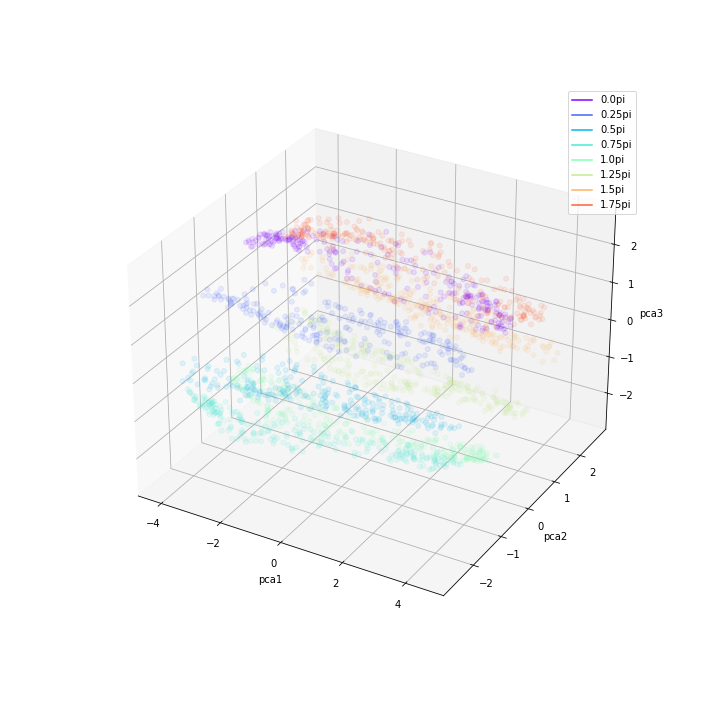

In [ ]:
%matplotlib widget
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plot_bg(pca_batch,ax)
#plot_categorisation_field(pca_batch,ax)
plt.show()